## Classification I 

Prepared by Dr. Kalpakis for CMSC 491/691, Fall 2017
 

### Import some modules

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import re

np.random.seed(0)

In [3]:
from sklearn import linear_model, model_selection, preprocessing, metrics, datasets
from sklearn.multiclass import OneVsRestClassifier
import statsmodels.api as sm

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Define some useful functions

In [4]:
def makeDataset(n_samples=500, n_features=4, n_classes=2):
    # wraper to generate synthetic classification datasets
    X,y = datasets.make_classification(n_samples=n_samples, n_features=n_features, 
                                      n_classes=n_classes, n_clusters_per_class=1,
                                      n_informative=n_features, n_redundant=0, n_repeated=0,
                                      weights=None, shuffle=True, random_state=0)

    predictors = ['Feat%1d' %(i+1) for i in range(n_features)]
    data = pd.DataFrame(X, columns=predictors)
    data['class'] = pd.Series(y)

    response = 'class'
    return (data, predictors, response, n_classes)

In [5]:
def isOneOfMany(y):
    if y.ndim > 1 and y.shape[1] > 1:
        return True
    return False

In [6]:
import inspect
def is_method(obj, name):
    val = False
    if hasattr(obj, name) and inspect.ismethod(getattr(obj, name)):
        val = True
    #print(obj, name, val)
    return val
    
def modelPredict(X_this, y_this, model):
    # y_hat, y_score, y_prob = modelPredict(X_this, y_this, model)
    y_hat = classifier.predict(X_this)
    y_score = np.zeros_like(y_this) #.fill(np.nan) 
    y_score = y_hat
    y_prob = np.zeros_like(y_this) #.fill(np.nan)
    y_prob = y_hat
    if is_method(model, 'decision_function'): 
        y_score = classifier.decision_function(X_this)
    if is_method(model, 'predict_proba'): 
        y_prob = classifier.predict_proba(X_this)
    return (y_hat, y_score, y_prob)

In [7]:
def classifierConfusionMatrix(y, y_hat, n_classes=2, class_labels=None, title=None, ax=None, cmap=plt.cm.Blues):
    # Construct and plot a multi-class confusion matrix; 
    # C[i,j] is the fraction of true class i predicted as class j
    
    if class_labels is None:
        class_labels = ['Class ' + str(i) for i in range(n_classes)]
        
    #Compute confusion matrix and then normalize it (row-wise)
    if isOneOfMany(y):
        cm = metrics.confusion_matrix(y.argmax(1), y_hat.argmax(1))
    else:
        cm = metrics.confusion_matrix(y, y_hat)
        
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = pd.DataFrame(cm, columns=class_labels, index=class_labels)
    #print("Normalized Confusion matrix\n", cm)
    
    if class_labels is None:
        class_labels = ['Class ' + str(i) for i in range(n_classes)]
    
    if ax is None:
        fig = plt.figure()
        ax = plt.gca()
    
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=True, yticklabels=True, cmap=cmap, ax=ax)
    ax.set_xlabel('Predicted class')
    ax.set_ylabel('True class')
    ax.set_title('Confusion Matrix [%s]' % title)

In [8]:
def plot1classROC(y, y_score, title='', ax=None):
    # assumes a binary classification problem, eg y is a single column array of 0 and 1's
    fpr, tpr, _ = metrics.roc_curve(y, y_score)
    roc_auc = metrics.auc(fpr, tpr)
    lw = 1
    if ax is None:
        plt.figure(figsize=(10, 8))
        ax = plt.gca()
        
    ax.plot(fpr, tpr, color='darkgreen', lw=1, label='ROC (auc = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    ax.set_title('ROC [%s]' % title)

In [9]:
def plotMultiClassROC(y, y_score, n_classes, title='', lw=1, ax=None, class_labels=None):
    # Compute macro-average ROC curve and ROC area for a multi-class classification where
    # y (and y_hat and y_score) is OneHot encoded eg it has n_classes columns 
    
    from scipy import interp
    from itertools import cycle
    
    if class_labels is None:
        class_labels = ['Class ' + str(i) for i in range(n_classes)]
        
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y.ravel(), y_score.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

    if ax is None:
        fig = plt.figure(figsize=(10, 8));
        ax = plt.gca()
        
    if class_labels is None:
        class_labels = ['class %d' % i for i in range(n_classes)]
        
    # Plot all ROC curves
    ax.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

    ax.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        label = class_labels[i]
        ax.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (auc = {1:0.2f})'
             ''.format(label, roc_auc[i]))

    ax.plot([0, 1], [0, 1], 'k--', lw=lw)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC [%s]' % title)
    ax.legend(loc="lower right")

In [10]:
def classifierPerformance(y, y_hat, y_score, n_classes=2, class_labels=None, title=None, ax=None):
    
    if class_labels is None:
        class_labels = ['Class ' + str(i) for i in range(n_classes)]
        
    print('Classification Report [%s]' % title)
    print(metrics.classification_report(y, y_hat, target_names=class_labels))

    print('Accuracy score= %.4f' % metrics.accuracy_score(y, y_hat))
    if isOneOfMany(y):
        ck = metrics.cohen_kappa_score(y.argmax(1), y_hat.argmax(1))
    else:
        ck = metrics.cohen_kappa_score(y, y_hat)
    
    print("Cohen's Kappa score= %.4f" % ck)
    
    classifierConfusionMatrix(y, y_hat, n_classes=n_classes, class_labels=class_labels, title=title)
    
    if n_classes == 2:
        plot1classROC(y, y_score, title=title, ax=ax)
    
    if n_classes > 2:
        plotMultiClassROC(y, y_score, n_classes, title=title, class_labels=class_labels, ax=ax)

## Load & explore a dataset

In [11]:
# load dataset, make it into a panda, and define the predictors/response attributes
ds = datasets.load_iris()
#print(ds['DESCR'])
#print(ds['feature_names'])

data = pd.DataFrame(ds.data,columns=ds.feature_names)
#data['const'] = 1
predictors = data.columns.tolist()
data['class'] = pd.Series(ds.target)
response = 'class'
n_classes = len(data[response].unique())

# comment out the next line if you like to generate synthetic data
#data, predictors, response, n_classes = makeDataset(n_samples=1000, n_features=3, n_classes=3)

In [12]:
data.head(5)
#data.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


### Extract design matrix (X,y) and class labels and values

In [13]:
predicted = response + "_pred"
class_vals = data[response].unique()
class_labels = [ 'class %d' % i for i in range(n_classes)]

print('Classes ', class_vals, class_labels)
#class_labels = ['A', 'B', 'C']

X = data[predictors].values
y = data[response].values

Classes  [0 1 2] ['class 0', 'class 1', 'class 2']


### Specify the classifier and model algorithm

In [14]:
# Binarize the response 
y = preprocessing.label_binarize(y, classes=class_vals)

#enc = preprocessing.OneHotEncoder(sparse=False)
#y = enc.fit_transform(y)

model = linear_model.LogisticRegression(C=1e5, solver='sag', multi_class='multinomial', max_iter=1000, 
                                        class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1,
                                        penalty='l2', tol=0.0001, verbose=0, warm_start=False)


from sklearn.linear_model import LogisticRegressionCV
#model = LogisticRegressionCV()

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
#model = LinearDiscriminantAnalysis()
#model = QuadraticDiscriminantAnalysis()

from sklearn.linear_model import RidgeClassifier
#model = RidgeClassifier()

from sklearn.svm import LinearSVC
#model = LinearSVC()

from sklearn.svm import SVC, NuSVC
#model = NuSVC(probability=True)

from sklearn.neighbors import KNeighborsClassifier
#model = KNeighborsClassifier()

from sklearn.naive_bayes import GaussianNB
#model = GaussianNB()

from sklearn.tree import DecisionTreeClassifier
#model = DecisionTreeClassifier()

from sklearn.ensemble import RandomForestClassifier
#model = RandomForestClassifier(max_depth=2)

from sklearn.gaussian_process import GaussianProcessClassifier
#model = GaussianProcessClassifier()

from sklearn.linear_model import PassiveAggressiveClassifier
#model = PassiveAggressiveClassifier()

from sklearn.linear_model import Perceptron
#model = Perceptron()

# Since we may have a multi-class classification problem,  will fit 1-vs-rest classifiers based on the model
classifier = OneVsRestClassifier(model)

# uncomment next line for just a binary classifier 
#classifier = model

### Fit classifier parameters to the training data

In [15]:
# shuffle and split training and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.5, random_state=0)

# fit the classifier to the training set
classifier = classifier.fit(X_train, y_train)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


### Apply classifier and get performance metrics

Classification Report [Testing]
             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00        21
    class 1       0.61      0.37      0.46        30
    class 2       0.96      1.00      0.98        24

avg / total       0.83      0.75      0.78        75

Accuracy score= 0.6400
Cohen's Kappa score= 0.4918


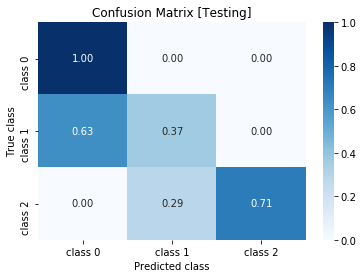

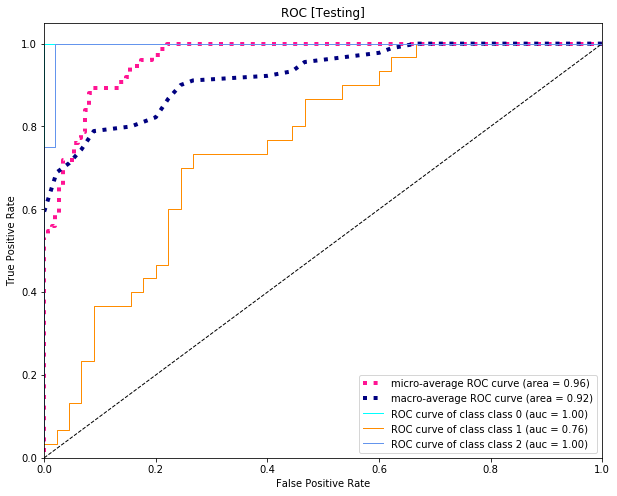

In [16]:
#debug
experiment, X_this, y_this = 'Training', X_train, y_train
experiment, X_this, y_this = 'Testing', X_test, y_test

y_hat, y_score, y_prob = modelPredict(X_this, y_this, model)

#try: 
#except Exception as e:

classifierPerformance(y_this, y_hat, y_score, n_classes, class_labels=class_labels, title=experiment)

### Examine classification scores for predictions

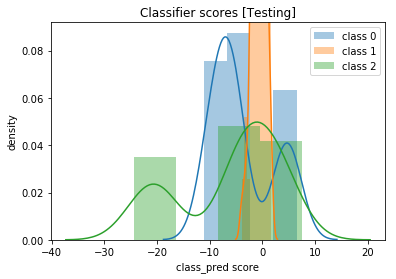

In [17]:
if isOneOfMany(y_this): 
    for i in range(n_classes):
        ax = sns.distplot(y_score[:,i], hist=True, kde=True, rug=False, norm_hist=True, label=class_labels[i])
else:
    ax = sns.distplot(y_score, hist=True, kde=True, rug=False, norm_hist=True, label=class_labels[1])  
ax.set_title('Classifier scores [%s]' % experiment )
ax.set_xlabel('%s score' % predicted)
ax.set_ylabel('density')
#ax.set_ylim([0,0.1])
ax.legend() 

### Examine specific ROCs

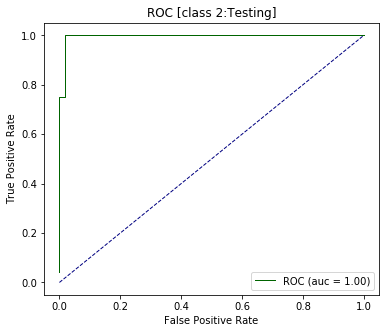

In [18]:
i = n_classes-1
plt.figure(figsize=(6,5))
ax =plt.gca()
if isOneOfMany(y_this): 
    plot1classROC(y_this[:,i], y_score[:,i], title=class_labels[i] + ":" + experiment, ax=ax)
else:
    plot1classROC(y_this, y_score, title=class_labels[1] + ":" + experiment, ax=ax)

### Embed observations in 2-d space and visualize dataset and classification results

In [19]:
#Dimensionality reduction/data projection methods
n_comps = min(3, X.shape[1])
neighbors = 13

comp_names = ["Comp" + str(x+1) for x in range(n_comps)]

from sklearn import decomposition
from sklearn import manifold
mds = manifold.MDS(n_components=n_comps, max_iter=100, n_init=1)

pca = decomposition.PCA(n_components=n_comps, svd_solver='auto')
spca = decomposition.SparsePCA(n_components=n_comps)
kpca = decomposition.KernelPCA(n_components=n_comps, kernel="rbf", gamma=10)
svd = decomposition.TruncatedSVD(n_components=n_comps, n_iter=10, random_state=0)

lle = manifold.LocallyLinearEmbedding(n_neighbors=neighbors, n_components=n_comps, eigen_solver='auto')
iso = manifold.Isomap(n_neighbors=neighbors, n_components=n_comps)
se = manifold.SpectralEmbedding(n_components=n_comps, n_neighbors=neighbors)
tsne = manifold.TSNE(n_components=n_comps, init='pca', random_state=0)

#choose which algorithm to use for dimensionality reduction
algorithm = pca

y_hat, y_score, y_prob = modelPredict(X_this, y_this, model)

Xprj = algorithm.fit_transform(X_this)

data_reduced= pd.DataFrame(Xprj, columns=comp_names)
data_reduced[response] = data[response]

if isOneOfMany(y_this):
    data_reduced[response] = y_this.argmax(1)
    data_reduced[predicted] = y_hat.argmax(1)
else:
    data_reduced[response] = y_this
    data_reduced[predicted] = y_hat

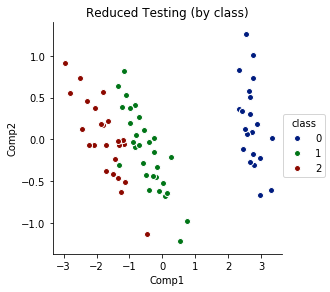

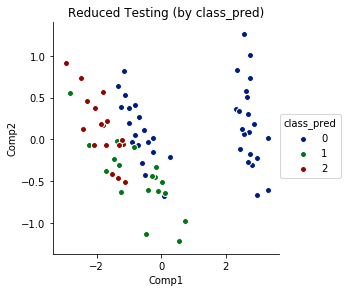

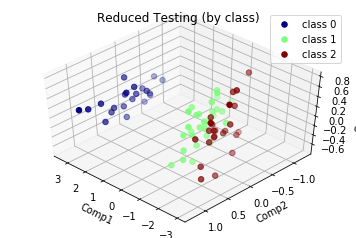

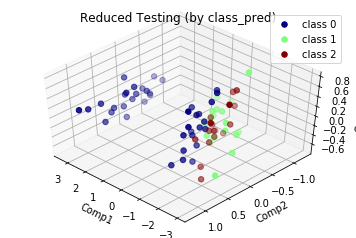

In [20]:
# plot reduced/projected data
cols = [data_reduced.columns[0], data_reduced.columns[1]]

for what in [response, predicted]:
    fig = plt.figure()
    g = sns.pairplot(x_vars=cols[0], y_vars=cols[1], data=data_reduced, hue=what, size=4, 
                     palette=sns.color_palette("dark", n_classes))
    ax = plt.gca()
    ax.set_title('Reduced %s ' % experiment + '(by %s)' % what )
    #ax.legend(loc='best')
    
from mpl_toolkits.mplot3d import Axes3D

from numpy import linspace
for what in [response, predicted]:
    if n_comps > 2:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d', elev=48, azim=134)
        colors = [ plt.cm.jet(i) for i in linspace(0, 1, n_classes)]
        for i in range(n_classes):
            df = data_reduced[ data_reduced[what] == i]
            ax.scatter(df.Comp1, df.Comp2, df.Comp3, c=colors[i], label='class %d' % i, s=30, marker='o')
        ax.set_xlabel(comp_names[0])
        ax.set_ylabel(comp_names[1])
        ax.set_zlabel(comp_names[2])
        ax.set_title('Reduced %s ' % experiment + '(by %s)' % what)
        ax.legend(loc='best')

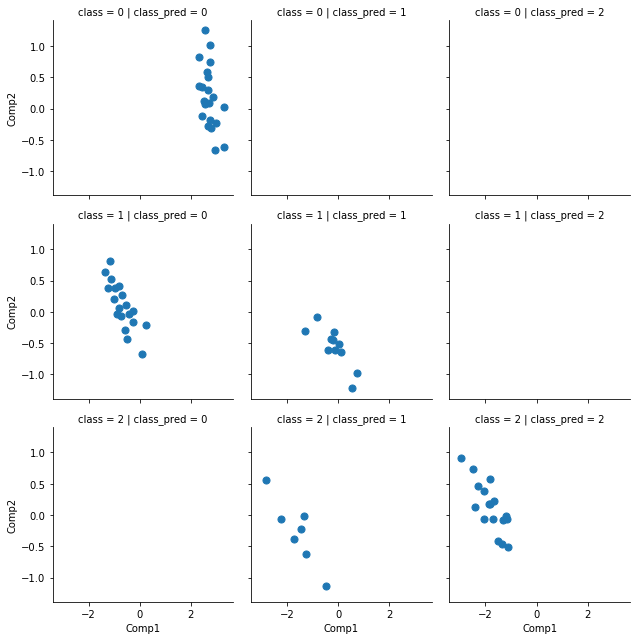

In [21]:
g = sns.FacetGrid(data_reduced, col=predicted, row=response) 
g.map(plt.scatter, cols[0], cols[1], marker='o', s=50)